# E-lerning project<a class="anchor" id="0-bullet"></a>

* [1. A/B testing](#1-bullet)
  * [1.1 Conditions](#1.1-bullet)
  * [1.2 Loading libraries and data](#1.2-bullet)
  * [1.3 Review](#1.3-bullet)
  * [1.4 Analysis](#1.4-bullet)
  * [1.5 Conclusions](#1.5-bullet)
* [2. SQL tasks](#2-bullet)
  * [2.1 Excellent student. Conditions and query](#2.1-bullet)
  * [2.2 Funnel optimization](#2.2-bullet)
* [3. Python task](#3-bullet)
  * [3.1 Automaticly recalculate metrics based on additional parameters](#3.1-bullet)
  * [3.2 Build graphs based on the resulting metrics](#3.2-bullet)

## 1. A/B testing <a class="anchor" id="1-bullet"></a>
[back to the table of contents](#0-bullet)

### 1.1 Conditions<a class="anchor" id="1.1-bullet"></a>

Testing hypothesis - target group used a new mechanics for paying for services on the site, while the control group used the basic mechanics.

Analyze the results of the experiment and draw a conclusion.Is it worth to launching a new payment mechanic for all users?

### 1.2 Loading libraries and data<a class="anchor" id="1.2-bullet"></a>

In [44]:
#data
import pandas as pd
import datetime as dt
import numpy as np
from datetime import timedelta

#API
import requests
from urllib.parse import urlencode

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#statisticf
from scipy.stats import norm 


#for displaying all pins - not only last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [45]:
path = '~/final_project/data/'

In [46]:
groups = pd.read_csv(path + 'groups.csv', sep=';')              # info about user-group (А – control, B – target group)
group_add = pd.read_csv(path + 'group_add.csv', sep=',')        # additional info about users-group
active_studs  = pd.read_csv(path + 'active_studs.csv', sep=';') # info about users who visited the platform during the days of the experiment.
checks  = pd.read_csv(path + 'checks.csv', sep=';')             # file with information about user payments on the days of the experiment.

In [2]:
#from API

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

links_dic = {
    'groups':       ['https://disk.yandex.ru/d/UhyYx41rTt3clQ', ';'],
    'groups_add':   ['https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', ','],
    'active_studs': ['https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', ','],
    'checks':       ['https://disk.yandex.ru/d/pH1q-VqcxXjsVA', ';']
            }

for csv_filename, csv_link in links_dic.items():
    final_url               = base_url + urlencode(dict(public_key=csv_link[0]))
    response                = requests.get(final_url)
    download_url            = response.json()['href']
    globals()[csv_filename] = pd.read_csv(download_url, sep=csv_link[1])


### 1.3 Review <a class="anchor" id="1.3-bullet"></a>

In [47]:
list_of_df = [groups, groups_add, active_studs, checks]
list_of_df_names = ['groups', 'groups_add', 'active_studs', 'checks']

In [48]:
#the firts view of dataframes
for i in range(len(list_of_df)):
    print('The first 2 rows from **{}**.' \
          .format('\033[1m' + list_of_df_names[i] + "\033[0;0m"))
    list_of_df[i].head(2)

The first 2 rows from **groups**.


,id,grp
0,1489,B
1,1627,A


The first 2 rows from **groups_add**.


,id,grp
0,5694584,B
1,5694830,B


The first 2 rows from **active_studs**.


,student_id
0,581585
1,5723133


The first 2 rows from **checks**.


,student_id,rev
0,1627,990.0
1,3185,690.0


In [49]:
#check the numbers of columns, the number of rows. For each column: type, number of Nans.

for i in range(len(list_of_df)):
    print('Main information for **{}**.' \
          .format('\033[1m' + list_of_df_names[i] + "\033[0;0m"))
    list_of_df[i].info()

Main information for **groups**.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
Main information for **groups_add**.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
Main information for **active_studs**.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
Main information for **checks**

In [50]:
#check the numbers of unique values for each columns
for i in range(len(list_of_df)):
    print('Unique values for **{}**.' \
          .format('\033[1m' + list_of_df_names[i] + "\033[0;0m"))
    list_of_df[i].nunique()

Unique values for **groups**.


id     74484
grp        2
dtype: int64

Unique values for **groups_add**.


id     92
grp     2
dtype: int64

Unique values for **active_studs**.


student_id    8341
dtype: int64

Unique values for **checks**.


student_id    541
rev            39
dtype: int64

In [9]:
#check the min and max payment from checks

print('Min payment {}.' \
          .format(checks.rev.min()))

print('Max payment {}.' \
          .format(checks.rev.max()))

Min payment 199.0.
Max payment 4650.0.


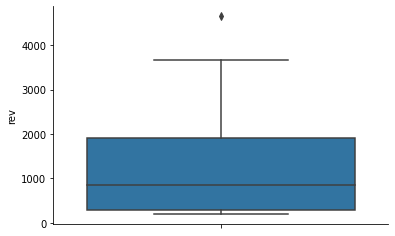

In [10]:
#check the distribution of rev from checks
sns.boxplot(data=checks, y='rev')
sns.despine()

In [51]:
#total_count of users in sample
groups_total = pd.concat([groups, group_add])

print('Total count of users in sample {}.' \
          .format(groups_total.shape[0]))

Total count of users in sample 74576.


In [52]:
#check number of users from the active list, who were't in the samlpe (groups_total)
print("Number of users from the active list, who were't in the samlpe:\n{}" \
          .format('\033[1m' + 
                  str(active_studs.query('student_id not in @groups_total.id').shape[0]) 
                  + '\033[1m'))


Number of users from the active list, who were't in the samlpe:
0


In [53]:
#check number of paid users who were't in the in the samlpe (groups_total)
print("Number of paid users who were't in the in the samlpe:\n{}" \
          .format('\033[1m' + 
                  str(active_studs.query('student_id not in @groups_total.id').shape[0]) 
                  + '\033[1m'))

Number of paid users who were't in the in the samlpe:
0


In [54]:
#check number of paid users who weren't in the in the active list:
print("Number of paid users who weren't in the in the active list:\n{}" \
          .format('\033[1m' + 
                  str(checks.query('student_id not in @active_studs.student_id').shape[0]) 
                  + '\033[1m'))

Number of paid users who weren't in the in the active list:
149


In [55]:
#check distribution of all users by groups:

print('Distribution of all users by groups \n{}\n'
          .format(pd.concat([groups_total.grp.value_counts(),
                             (groups_total.grp.value_counts(normalize=True) \
                             .mul(100).round(1).astype(str) + '%')],
                           axis=1, keys=['count', 'percentage'])))

print('Total:', groups_total.grp.value_counts().sum())

Distribution of all users by groups 
   count percentage
B  59883      80.3%
A  14693      19.7%

Total: 74576


In [56]:
#check distribution of all paid users in sanple by groups:

print('Distribution of all paid users in sample by groups \n{}\n'
          .format(pd.concat([groups_total.query('id in @checks.student_id').grp.value_counts(),
                             (groups_total.query('id in @checks.student_id').grp.value_counts(normalize=True) \
                             .mul(100).round(1).astype(str) + '%')],
                           axis=1, keys=['count', 'percentage'])))

print('Total:', groups_total.query('id in @checks.student_id').grp.value_counts().sum())

Distribution of all paid users in sample by groups 
   count percentage
B    434      80.2%
A    107      19.8%

Total: 541


In [57]:
#check distribution of all active users in sample by groups:

print('Distribution of all active users in sample by groups \n{}\n'
          .format(pd.concat([groups_total.query('id in @active_studs.student_id').grp.value_counts(),
                             (groups_total.query('id in @active_studs.student_id').grp.value_counts(normalize=True) \
                             .mul(100).round(1).astype(str) + '%')],
                           axis=1, keys=['count', 'percentage'])))

print('Total:', groups_total.query('id in @active_studs.student_id').grp.value_counts().sum())

Distribution of all active users in sample by groups 
   count percentage
B   6803      81.6%
A   1538      18.4%

Total: 8341


In [58]:
#check distribution of all active and paid users in sample by groups:

print('Distribution of all active and paid users in sample by groups \n{}\n'
          .format(pd.concat([groups_total.query('id in @active_studs.student_id & id in @checks.student_id').grp.value_counts(),
                             (groups_total.query('id in @active_studs.student_id & id in @checks.student_id').grp.value_counts(normalize=True) \
                             .mul(100).round(1).astype(str) + '%')],
                           axis=1, keys=['count', 'percentage'])))

print('Total:', groups_total.query('id in @active_studs.student_id & id in @checks.student_id').grp.value_counts().sum())

Distribution of all active and paid users in sample by groups 
   count percentage
B    314      80.1%
A     78      19.9%

Total: 392


In [59]:
#check distribution of all active but not paid users in sample by groups:

print('Distribution of all active and not paid users in sample by groups \n{}\n'
          .format(pd.concat([groups_total.query('id in @active_studs.student_id & id not in @checks.student_id').grp.value_counts(),
                             (groups_total.query('id in @active_studs.student_id & id not in @checks.student_id').grp.value_counts(normalize=True) \
                             .mul(100).round(1).astype(str) + '%')],
                           axis=1, keys=['count', 'percentage'])))

print('Total:', groups_total.query('id in @active_studs.student_id & id not in @checks.student_id').grp.value_counts().sum())

Distribution of all active and not paid users in sample by groups 
   count percentage
B   6489      81.6%
A   1460      18.4%

Total: 7949


In [61]:
#check distribution of all not active but paid users in sample by groups (149 cases):

print('Distribution of all not active but paid users in sample by groups \n{}\n'
          .format(pd.concat([groups_total.query('id not in @active_studs.student_id & id in @checks.student_id').grp.value_counts(),
                             (groups_total.query('id not in @active_studs.student_id & id in @checks.student_id').grp.value_counts(normalize=True) \
                             .mul(100).round(1).astype(str) + '%')],
                           axis=1, keys=['count', 'percentage'])))

print('Total:', groups_total.query('id not in @active_studs.student_id & id in @checks.student_id').grp.value_counts().sum())

Distribution of all not active but paid users in sample by groups 
   count percentage
B    120      80.5%
A     29      19.5%

Total: 149


**Conclusions after the review:** 
* 1. There aren't Nans in dfs.
* 2. 2 unique values for group in groups and group_add.
* 3. Users are distributed unevenly across groups. Group B is significantly larger than Group A.
* 4. Theer is 149 users, who weren't active, but paid - it's strange cases - wouldn't use it in sample for testing.

### 1.4 Analysis <a class="anchor" id="1.4-bullet"></a>

In [62]:
#because we decided to use paid and active users and not use paid and unactive
active_paid = ( active_studs
                .merge(checks, how='left', on='student_id'))

#add info about payiment to the users in sample

active_total = groups_total.merge(active_paid, 
                                  how='right',
                                  left_on = 'id',
                                  right_on = 'student_id')

active_total['rev'] = active_total.rev.fillna(0)     
active_total.head()

,id,grp,student_id,rev
0,581585,A,581585,0.0
1,5723133,A,5723133,0.0
2,3276743,B,3276743,0.0
3,4238589,A,4238589,0.0
4,4475369,B,4475369,0.0


Let's see the distribution of payment for each group.

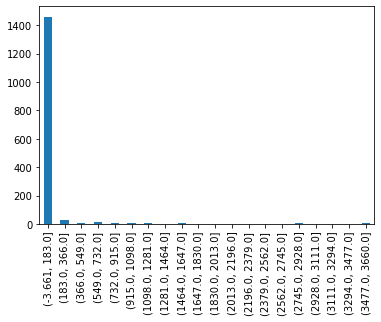

In [64]:
active_total.query('grp == "A"')['rev'].value_counts(sort=False, bins=20).plot.bar()

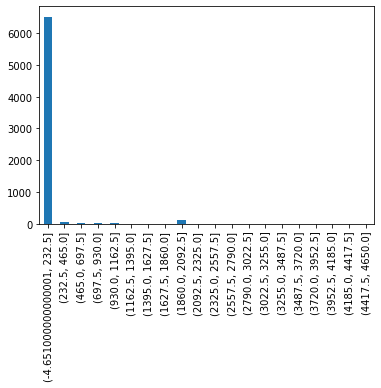

In [115]:
active_total.query('grp == "B"')['rev'].value_counts(sort=False, bins=20).plot.bar()

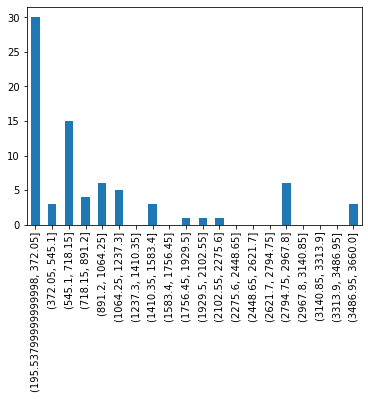

In [118]:
active_total.query('grp == "A" & rev >0')['rev'].value_counts(sort=False, bins=20).plot.bar()

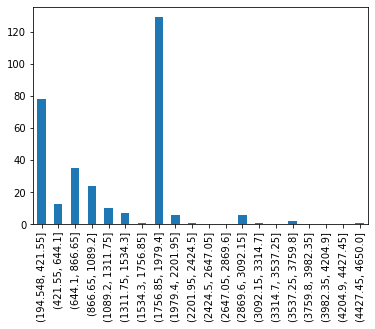

In [119]:
active_total.query('grp == "B" & rev >0')['rev'].value_counts(sort=False, bins=20).plot.bar()

To conduct an experiment and subsequently analyze whether it is worth launching a new payment mechanic for all users, we need to select the metrics by which the evaluation will be made.

To my mind, the most suitable metrics will be ARPU and ARPPU.


**ARPU** is usually calculated as total revenue divided by the number of units, users, or subscribers.

Average revenue per paying user (**ARPPU**) is a measurement that app marketers use to figure out how much revenue is generated by paying users and players, on average, over a certain time period.


In [65]:
print('\n\033[1mARPU\033[0m\nRatio of the total amount to the number of active users:\nGroup A:',
                                                                          round(active_total.query('grp == "A" & rev >0').rev.sum() / active_total.query('grp == "A"').id.count(), 2),
                                                                          '\nГруппа В:', 
                                                                          round(active_total.query('grp == "B" & rev >0').rev.sum() / active_total.query('grp == "B"').id.count(), 2),
      '\nARPU for Group B', 
      round((round(active_total.query('grp == "B" & rev >0').rev.sum() / active_total.query('grp == "B"').id.count(), 2) - round(active_total.query('grp == "A" & rev >0').rev.sum() / active_total.query('grp == "A"').id.count(), 2)) /
      round(active_total.query('grp == "A" & rev >0').rev.sum() / active_total.query('grp == "A"').id.count(), 2) * 100, 2), '%',
      'more, than ARPU for Group A')

print('\n\033[1mARPPU \033[0m\nRatio of the total amount to the number of active paid users\nGroup А:',
                                                                                      round(active_total.query('grp == "A" & rev >0').rev.mean(), 2), 
                                                                                     '\nGroup В:', 
                                                                                      round(active_total.query('grp == "B" & rev >0').rev.mean(), 2),
      '\nARPPU for Group B', round(round(active_total.query('grp == "B" & rev >0').rev.mean() - active_total.query('grp == "A" & rev >0').rev.mean(), 2) /
                             round(active_total.query('grp == "A" & rev >0').rev.mean(), 2) * 100, 2),'%',
      'more, than ARPPU for Group A')


ARPU
Ratio of the total amount to the number of active users:
Group A: 47.35 
Группа В: 58.06 
ARPU for Group B 22.62 % more, than ARPU for Group A

ARPPU 
Ratio of the total amount to the number of active paid users
Group А: 933.59 
Group В: 1257.88 
ARPPU for Group B 34.74 % more, than ARPPU for Group A


#### Are these differences statistically significant?

To get answers, we need to use statistical tests. Classical statistical tests such as t-test wouldn't work properly, because group sizes vary greatly. In such cases, bootstrap will be better.

## For ARPU

* H0: The ARPUs in the two groups are the same.
* H1: ARPUs differ between the two groups.

In [66]:
data = []
for i in range(1000):        # creating samples
        samples_1 = active_total.query('grp == "A"').rev.sample(
            len(active_total.query('grp == "B"').rev), 
            replace = True                  
        ).values
        
        samples_2 = active_total.query('grp == "B"').rev.sample(
            len(active_total.query('grp == "B"').rev), 
            replace = True
        ).values
        
        samples_delta = samples_2 - samples_1      # difference between samples
        data.append(np.mean(samples_delta)) 
        
df_data = pd.DataFrame(data)

# confidence interval (using bootstrap confidence level = 0.95)
left_quant  = (1 - 0.95)/2
right_quant = 1 - (1 - 0.95) / 2
ci = df_data.quantile([left_quant, right_quant])

p_1 = norm.cdf(
    x     = 0, 
    loc   = np.mean(data), 
    scale = np.std(data)
)
p_2 = norm.cdf(
    x     = 0, 
    loc   = -np.mean(data), 
    scale = np.std(data)
)
p_value = min(p_1, p_2) * 2

print('\n\033[1mci \033[0m\n {}'.format(ci))
print('\n\033[1mp_value \033[0m = {}'.format(p_value))


ci 
                0
0.025   1.072509
0.975  21.175004

p_value  = 0.03223224421509818


The confidence interval does not include 0, we reject the null hypothesis. The ARPUs in the two groups are different.

## For ARPPU

* H0: The ARPPUs in the two groups are the same.
* H1: ARPPUs differ between the two groups.

In [34]:
data = []
for i in range(1000):        # creating samples
        samples_1 = active_total.query('grp == "A" & rev >0').rev.sample(
            len(active_total.query('grp == "B" & rev >0').rev), 
            replace = True                  
        ).values
        
        samples_2 = active_total.query('grp == "B" & rev >0').rev.sample(
            len(active_total.query('grp == "B"& rev >0').rev), 
            replace = True
        ).values
        
        samples_delta = samples_2 - samples_1      # difference between samples
        data.append(np.mean(samples_delta)) 
        
df_data = pd.DataFrame(data)

# confidence interval (using bootstrap confidence level = 0.95)
left_quant  = (1 - 0.95)/2
right_quant = 1 - (1 - 0.95) / 2
ci = df_data.quantile([left_quant, right_quant])

p_1 = norm.cdf(
    x     = 0, 
    loc   = np.mean(data), 
    scale = np.std(data)
)
p_2 = norm.cdf(
    x     = 0, 
    loc   = -np.mean(data), 
    scale = np.std(data)
)
p_value = min(p_1, p_2) * 2

print('\n\033[1mci \033[0m\n {}'.format(ci))
print('\n\033[1mp_value \033[0m = {}'.format(p_value))


ci 
                 0
0.025  199.963547
0.975  451.673261

p_value  = 6.186978278577758e-07


The confidence interval does not include 0, we reject the null hypothesis. The ARPUs in the two groups are different.

### 1.5 Conclusions <a class="anchor" id="1.5-bullet"></a>

Is it worth to launching a new payment mechanics for all users? - Yes, the new payment mechanics shows a statistically significant increase in the ARPU and ARPPU metrics;

## 2. SQL tasks <a class="anchor" id="2-bullet"></a>
[back to the table of contents](#0-bullet)

### 2.1 Excellent student. Conditions and query <a class="anchor" id="2.1-bullet"></a>

Educational courses consist of various lessons, each lessons consists of several small tasks. Small task is called a “pea”.

The excellent student - user who solved 20 peas (Small tasks) correctly at least once during the current month.

Find the number of excellent student.

Table default.peas

| Attribute name| Attribute type | Meaning                       |   |   |
|-------------------|--------------|------------------------------------------|---|---|
| st_id             | int          | ID student                               |   |   |
| timest            | timestamp    | Task solution time                   |   |   |
| correct           | bool         | Solved correctly?            |   |   |
| subject           | text         | Subject   |   |   |

In [38]:
sql = '''
    WITH cte_1 as (
        SELECT  
            st_id, 
            timest,
            SUM(correct) OVER (PARTITION BY st_id) AS peas_per_month
        FROM default.peas)    
    SELECT 
    COUNT(DISTINCT sq.st_id) AS excellent students 
    FROM cte_1
    WHERE peas_per_month > 20;
'''

### 2.2 Funnel optimization <a class="anchor" id="2.2-bullet"></a>

It is necessary to upload the following information about user groups in one request:

- ARPU
- ARPAU
- CR for purchase
- CR of an active user for purchase
- User CR from math activity (subject = 'math') to purchase a math course

For ARPU - all users included in groups. A user is considered active if he has solved more than 10 problems correctly in any discipline. A user is considered active in mathematics if he has solved 2 or more problems in mathematics correctly over the entire period of time.

Table default.peas

| Attribute name| Attribute type | Meaning                 |   |   |
|-------------------|--------------|-----------------------|---|---|
| st_id             | int          | ID student            |   |   |
| timest            | timestamp    | Task solution time    |   |   |
| correct           | bool         | Solved correctly?     |   |   |
| subject           | text         | Subject               |   |   |

Table default.studs

| Attribute name| Attribute type | Meaning                                    |   |   |
|-------------------|--------------|------------------------------------------|---|---|
| st_id             | int          | ID student                               |   |   |
| test_grp          | text         | student label in this experiment          |   |   |


Table default.final_project_check

| Attribute name    | Attribute type | Meaning                   |   |   |
|-------------------|--------------|-----------------------------|---|---|
| st_id             | int          | ID student                  |   |   |
| sale_time         | timestamp    | Purchase's time             |   |   |
| money             | int          | Price                       |   |   |
| subject           | text         | Subject                     |   |   |


In [ ]:
sql = '''

WITH cte_1   /* Active stidents */
AS (

SELECT actives.st_id, 
       MAX(
       CASE WHEN actives.peas_per_day >= 30 
       THEN 1 
       ELSE 0 END) AS active_in_total
FROM (

    SELECT
    st_id, 
    timest, 
    SUM(correct) OVER (PARTITION BY st_id ORDER BY timest
                       RANGE BETWEEN '1 day' PRECEDING AND CURRENT ROW) AS peas_per_day, 
    subject
    FROM peas
    
    )
GROUP BY st_id
),
cte_2   /* Active stidents for math */
AS (
  
SELECT active_by_subj.st_id, 
        MAX(CASE WHEN active_by_subj.math_per_day >= 30 
        THEN 1 ELSE 0 END) AS active_in_math
FROM (

     SELECT 
     st_id, 
     timest, 
     SUM(correct) OVER (PARTITION BY st_id, subject ORDER BY timest 
                        RANGE BETWEEN '1 day' PRECEDING AND CURRENT ROW)  AS math_per_day, 
     subject
     FROM peas 
     
      )
            
GROUP BY st_id
),
cte_3  /* Purchase the course, math*/
AS (
 
SELECT st_id, SUM(money) AS money,
        1 AS sale_subject,
        MAX(CASE WHEN subject = 'math' THEN 1 ELSE 0 END) AS sale_math
FROM checks 
GROUP BY st_id

)
SELECT 
 studs.test_grp, 
 COALESCE(SUM(s.money), 0) / COUNT(at.st_id) AS ARPU,
 COALESCE(SUM(s.money), 0) / SUM(at.active_in_total) AS ARPAU,
 COALESCE(SUM(s.sale_subject), 0) / COUNT(at.st_id) AS CR,
 SUM(CASE WHEN at.active_in_total = 1 AND s.sale_subject = 1 THEN 1 ELSE 0 END) / SUM(at.active_in_total) AS СR_active,
 SUM(CASE WHEN am.active_in_math = 1 AND s.sale_math = 1 THEN 1 ELSE 0 END) / SUM(am.active_in_math) AS CR_math
FROM cte_1 at
JOIN cte_2 am USING (st_id)
JOIN studs ON at.st_id = studs.st_id
LEFT JOIN cte_3 s ON at.st_id = s.st_id
GROUP BY test_grp
'''

## 3. Python task <a class="anchor" id="3-bullet"></a>
[back to the table of contents](#0-bullet)

### 3.1 Automaticly recalculate metrics based on additional parameters <a class="anchor" id="3.1-bullet"></a>

Implement a function that will automatically load information from the additional file groups_add.csv (headers may differ) and recalculate metrics based on additional parameters.

In [16]:
# use active_total from A/B testing task as main df

work_df = (
    groups
    .merge(
        active_studs
            .assign(activity=1)
            .rename(columns={'student_id': 'id'})
        ,on='id', how='outer'
        )
    .merge(
        checks
            .assign(payment = 1)
            .rename(columns={'student_id': 'id'})
        ,on='id', how='outer'
    )
)
work_df.head()

,id,grp,activity,rev,payment
0,1489,B,NaN,NaN,NaN
1,1627,A,1.0,990.0,1.0
2,1768,B,NaN,NaN,NaN
3,1783,B,NaN,NaN,NaN
4,1794,A,NaN,NaN,NaN


In [17]:
# func for rename columns

def columns_renamer(df):
    if str(df.iloc[0, 0]).isalpha():
        df.columns = ['grp', 'id']
    else:
        df.columns = ['id', 'grp']

In [79]:
def get_update(work_df, link, final=False):
    # download additional file
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    final_url    = base_url + urlencode(dict(public_key=link))
    response     = requests.get(final_url)
    download_url = response.json()['href']
    group_add_df = pd.read_csv(download_url, sep=',')

    # rename the columns according to the data type
    columns_renamer(group_add_df)
    
    # combine the main df with an additional one
    work_df = work_df.merge(group_add_df, on='id', how='outer')
    work_df['grp_x'] = work_df.grp_x.fillna('')                  
    work_df['grp_y'] = work_df.grp_y.fillna('')                  
    work_df['grp']= work_df.grp_x + work_df.grp_y             
    work_df = work_df.drop(['grp_x', 'grp_y'], axis=1)  
    
    #assign step values in the added lines
    work_df = work_df.assign(step=0)
    template = work_df.id.isin(group_add_df.id)
    work_df.loc[template, 'step'] = work_df.step.max() + 1  
    work_df['step'] = work_df.step.astype('int')
    
    # let's use only active ones
    work_df = (work_df
         .copy()
         .dropna(subset=['activity', 'grp'])
         )
    for i in ['payment', 'rev']:
        work_df[i] = work_df[i].fillna(0)
    
    # Let's recalculate the metrics, each cycle - a new addition of the groups_add file
    df_ab = pd.DataFrame() 

    for i in range(work_df.step.max() + 1): 
        payment_a      = work_df.query('step <= @i and grp =="A"').payment               
        payment_b      = work_df.query('step <= @i and grp =="B"').payment
        rev_all_a      = work_df.query('step <= @i and grp =="A"').rev
        rev_all_b      = work_df.query('step <= @i and grp =="B"').rev
        rev_positive_a = work_df.query('step <= @i and rev > 0 and grp =="A"').rev
        rev_positive_b = work_df.query('step <= @i and rev > 0 and grp =="B"').rev

        #CR_a
        cr_a = sum(payment_a) / len(payment_a)
        #CR_b
        cr_b = sum(payment_b) / len(payment_b)
        #CR p-value
        data_cr = []
        for i in range(1000):        # creating samples
                samples_1 = payment_a 
                samples_2 = payment_b
                samples_delta = samples_2 - samples_1      # difference between samples
                data_cr.append(sum(samples_delta) / len(samples_delta)) 

        df_data_cr = pd.DataFrame(data_cr)

        # confidence interval (using bootstrap confidence level = 0.95)
        left_quant  = (1 - 0.95)/2
        right_quant = 1 - (1 - 0.95) / 2
        ci = df_data_cr.quantile([left_quant, right_quant])

        p_1 = norm.cdf(
            x     = 0, 
            loc   = np.mean(data_cr), 
            scale = np.std(data_cr)
        )
        p_2 = norm.cdf(
            x     = 0, 
            loc   = -np.mean(data_cr), 
            scale = np.std(data_cr)
        )
        p_value = min(p_1, p_2) * 2
        cr_p_value = p_value

        #ARPU_a
        arpu_a = np.mean(rev_all_a)
        #ARPU_b
        arpu_b = np.mean(rev_all_b)
        #ARPU p-value
        data_arpu = []
        for i in range(1000):        # creating samples
                samples_1 = rev_all_a  
                samples_2 = rev_all_b
                samples_delta = samples_2 - samples_1      # difference between samples
                data_arpu.append(np.mean(samples_delta)) 

        df_data_arpu = pd.DataFrame(data_arpu)

        # confidence interval (using bootstrap confidence level = 0.95)
        left_quant  = (1 - 0.95)/2
        right_quant = 1 - (1 - 0.95) / 2
        ci = df_data_arpu.quantile([left_quant, right_quant])

        p_1 = norm.cdf(
            x     = 0, 
            loc   = np.mean(data_arpu), 
            scale = np.std(data_arpu)
        )
        p_2 = norm.cdf(
            x     = 0, 
            loc   = -np.mean(data_arpu), 
            scale = np.std(data_arpu)
        )
        p_value = min(p_1, p_2) * 2
        arpu_p_value = p_value
        #ARPPU_a
        arppu_a = np.mean(rev_positive_a)
        #ARPPU_b
        arppu_b = np.mean(rev_positive_b)
        #ARPPU p-value
        data_arppu = []
        for i in range(1000):        # creating samples
                samples_1 = rev_positive_a  
                samples_2 = rev_positive_b
                samples_delta = samples_2 - samples_1      # difference between samples
                data_arppu.append(np.mean(samples_delta)) 

        df_data_arppu = pd.DataFrame(data_arppu)

        # confidence interval (using bootstrap confidence level = 0.95)
        left_quant  = (1 - 0.95)/2
        right_quant = 1 - (1 - 0.95) / 2
        ci = df_data_arppu.quantile([left_quant, right_quant])

        p_1 = norm.cdf(
            x     = 0, 
            loc   = np.mean(data_arppu), 
            scale = np.std(data_arppu)
        )
        p_2 = norm.cdf(
            x     = 0, 
            loc   = -np.mean(data_arppu), 
            scale = np.std(data_arppu)
        )
        p_value = min(p_1, p_2) * 2
        arppu_p_value = p_value
    
    temp_df = pd.DataFrame([[cr_a, 
                             cr_b, 
                             cr_p_value, 
                             arpu_a, 
                             arpu_b, 
                             arpu_p_value, 
                             arppu_a, 
                             arppu_b, 
                             arppu_p_value]],
                           columns=['CR_A',
                                    'CR_B',
                                    'CR_p-value',
                                    'ARPU_A',
                                    'ARPU_B',
                                    'ARPU_p-value', 
                                    'ARPPU_A',
                                    'ARPPU_B',
                                    'ARPPU_p-value'])
    # добавляем строку в итоговый дф
    df_ab = pd.concat([df_ab, temp_df])      

    # сбрасываем индексы
    df_ab.reset_index(drop=True, inplace=True)  
    df_ab['step'] = df_ab.index
    if final == True:
        return df_ab.tail(1)

    return df_ab

In [80]:
metrix = get_update(work_df, link)
metrix

,CR_A,CR_B,CR_p-value,ARPU_A,ARPU_B,ARPU_p-value,ARPPU_A,ARPPU_B,ARPPU_p-value,step
0,0.050715,0.046156,NaN,47.347204,58.058798,NaN,933.589744,1257.878992,NaN,0


### 3.2 Build graphs based on the resulting metrics <a class="anchor" id="3.2-bullet"></a>

Implement a function that will build graphs based on the resulting metrics.

In [81]:
def get_graphs(df):
    metrix_df = pd.DataFrame(columns = ['step', 'group'])                     
    for i in ['CR_', 'ARPU_', 'ARPPU_']:                                      
        cols    = df.filter(like = i).columns                                 
        temp_df = pd.DataFrame()                                              
        for j in cols[:2]:                                                    
            tmp_row         = df[[j, 'step']] \
            .assign(group = j[-1:]) \
            .rename(columns = {j: j[:-2]})  
            temp_df         = pd.concat([temp_df, tmp_row])                   
        metrix_df = metrix_df \
                    .merge(temp_df, on=['step', 'group'], how='right')        
    
    figure, axes = plt.subplots(2, 3, sharex=True, figsize=(16,7))   
    
    figure.suptitle('p-value', fontsize=20)
    
    sns.lineplot(ax=axes[0, 0], data=metrix_df, x='step', y='CR', hue='group', linewidth=2)
    ax1 = sns.lineplot(ax=axes[1, 0], data=df, x='step', y='CR_p-value', linewidth=2, color="#5fa0c6", label='p-value')
    ax1.axhline(0.05, ls='--', linewidth=1.5, color=(1, 0, 0, 0.7), label='p-value = 0.05')
    ax1.set_ylabel('P-value `for CR')
    ax1.set_xlabel('Time of upload')
    ax1.legend()
    
    sns.lineplot(ax=axes[0, 1], data=metrix_df, x='step', y='ARPU', hue='group', linewidth=2)
    ax2 = sns.lineplot(ax=axes[1, 1], data=df, x='step', y='ARPU_p-value', linewidth=2, color="#5fa0c6", label='p-value')
    ax2.axhline(0.05, ls='--', linewidth=1.5, color=(1, 0, 0, 0.7), label='p-value = 0.05')
    ax2.set_ylabel('P-value for ARPU')
    ax2.set_xlabel('Time of upload')
    ax2.legend()
 
    sns.lineplot(ax=axes[0, 2], data=metrix_df, x='step', y='ARPPU', hue='group', linewidth=2)
    ax3 = sns.lineplot(ax=axes[1, 2], data=df, x='step', y='ARPPU_p-value', linewidth=2, color="#5fa0c6", label='p-value')
    ax3.axhline(0.05, ls='--', linewidth=1.5, color=(1, 0, 0, 0.7), label='p-value = 0.05')
    ax3.set_ylabel('P-value for ARPPU ')
    ax3.set_xlabel('Time of upload')
    ax3.set_xticks(range(0, metrix_df.step.max() + 1))  
    ax3.legend()
    
    plt.gcf().get_axes()[0].set_ylim(0, metrix_df.CR.max() * 1.1)                  
    plt.gcf().get_axes()[1].set_ylim(0, metrix_df.ARPU.max() * 1.1)
    plt.gcf().get_axes()[2].set_ylim(0, metrix_df.ARPPU.max() * 1.1)
    plt.gcf().get_axes()[3].set_ylim(-0.001, max(0.05, metrix['CR_p-value'].max()) * 1.1)
    plt.gcf().get_axes()[4].set_ylim(-0.001, max(0.05, metrix['ARPU_p-value'].max()) * 1.1)
    plt.gcf().get_axes()[5].set_ylim(-0.001, max(0.05, metrix['ARPPU_p-value'].max()) * 1.1)
    
    # добавляем расстояния между графиками
    plt.subplots_adjust(top=0.92, hspace = 0.1, wspace=0.3)

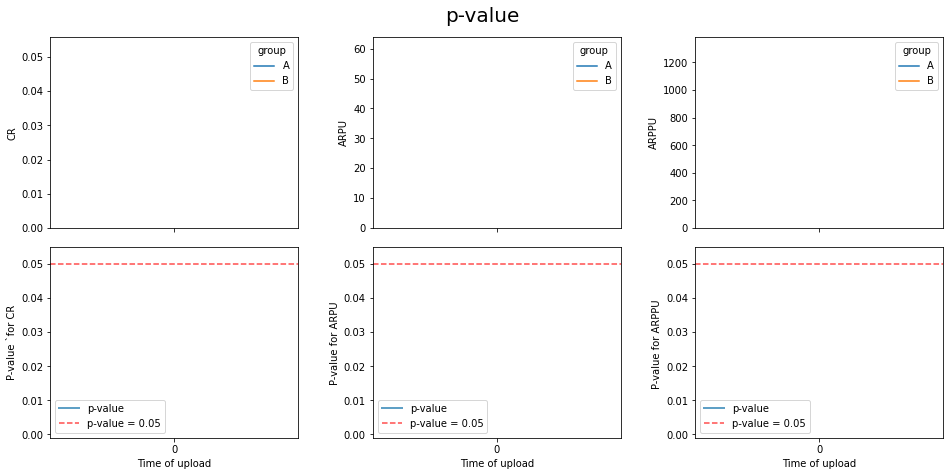

In [82]:
get_graphs(metrix)